In [1]:
import pandas as pd
import numpy as np
df = pd.read_csv('BPD_Part_1_Victim_Based_Crime_Data.csv')
df.head()

,CrimeDate,CrimeTime,CrimeCode,Location,Description,Inside/Outside,Weapon,Post,District,Neighborhood,Location 1,Total Incidents
0,11-12-2016,02:35:00,3B,300 SAINT PAUL PL,ROBBERY - STREET,O,NaN,111.0,CENTRAL,Downtown,"(39.2924100000, -76.6140800000)",1
1,11-12-2016,02:56:00,3CF,800 S BROADWAY,ROBBERY - COMMERCIAL,I,FIREARM,213.0,SOUTHEASTERN,Fells Point,"(39.2824200000, -76.5928800000)",1
2,11-12-2016,03:00:00,6D,1500 PENTWOOD RD,LARCENY FROM AUTO,O,NaN,413.0,NORTHEASTERN,Stonewood-Pentwood-Winston,"(39.3480500000, -76.5883400000)",1
3,11-12-2016,03:00:00,6D,6600 MILTON LN,LARCENY FROM AUTO,O,NaN,424.0,NORTHEASTERN,Westfield,"(39.3626300000, -76.5516100000)",1
4,11-12-2016,03:00:00,6E,300 W BALTIMORE ST,LARCENY,O,NaN,111.0,CENTRAL,Downtown,"(39.2893800000, -76.6197100000)",1


In [2]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 285807 entries, 0 to 285806
Data columns (total 12 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   CrimeDate        285807 non-null  object 
 1   CrimeTime        285807 non-null  object 
 2   CrimeCode        285807 non-null  object 
 3   Location         284184 non-null  object 
 4   Description      285807 non-null  object 
 5   Inside/Outside   281611 non-null  object 
 6   Weapon           97396 non-null   object 
 7   Post             285616 non-null  float64
 8   District         285749 non-null  object 
 9   Neighborhood     284106 non-null  object 
 10  Location 1       284188 non-null  object 
 11  Total Incidents  285807 non-null  int64  
dtypes: float64(1), int64(1), object(10)
memory usage: 26.2+ MB


In [3]:
data=df

### Consider the crimes of LARCENY (Crime code starting with 6), BURGLARY (Crime code starting with 5).
- Create two timeseries datasets LarcenyTs, BurglaryTs to represent the total number of crimes , day-wise. Put data from 2014, 2015 into training and predict the total number of LARCENY and BURGLARY crimes for the year 2016.  


In [4]:
# Converting the date column to datetime format
data['CrimeDate'] = pd.to_datetime(data['CrimeDate'])

# Filtering out Larceny and Burglary crimes
larceny_crimes = data[data['CrimeCode'].str.startswith('6')]  # Larceny: Crime code starting with 6
burglary_crimes = data[data['CrimeCode'].str.startswith('5')]  # Burglary: Crime code starting with 5

In [5]:
# Group by date and count total incidents
larceny_ts = larceny_crimes.groupby('CrimeDate').agg({'Total Incidents': 'sum'}).resample('D').fillna(0)
burglary_ts = burglary_crimes.groupby('CrimeDate').agg({'Total Incidents': 'sum'}).resample('D').fillna(0)

# Splitting the data into training and testing sets
larceny_train = larceny_ts['2014':'2015']
larceny_test = larceny_ts['2016']

burglary_train = burglary_ts['2014':'2015']
burglary_test = burglary_ts['2016']

C:\Users\Shriya Bhat\AppData\Local\Temp\ipykernel_16696\3027994982.py:7: FutureWarning: Indexing a DataFrame with a datetimelike index using a single string to slice the rows, like `frame[string]`, is deprecated and will be removed in a future version. Use `frame.loc[string]` instead.
  larceny_test = larceny_ts['2016']
C:\Users\Shriya Bhat\AppData\Local\Temp\ipykernel_16696\3027994982.py:10: FutureWarning: Indexing a DataFrame with a datetimelike index using a single string to slice the rows, like `frame[string]`, is deprecated and will be removed in a future version. Use `frame.loc[string]` instead.
  burglary_test = burglary_ts['2016']


In [6]:
larceny_train

,Total Incidents
CrimeDate,
2014-01-01,46
2014-01-02,34
2014-01-03,20
2014-01-04,37
2014-01-05,31
...,...
2015-12-27,36
2015-12-28,39
2015-12-29,47


In [7]:
burglary_test

,Total Incidents
CrimeDate,
2016-01-01,18
2016-01-02,6
2016-01-03,22
2016-01-04,24
2016-01-05,16
...,...
2016-11-08,19
2016-11-09,26
2016-11-10,24


In [12]:
from sklearn.preprocessing import MinMaxScaler

larceny_values = larceny_train['Total Incidents'].values.reshape(-1, 1)
burglary_values = burglary_train['Total Incidents'].values.reshape(-1, 1)

# Normalize the datasets
scaler_larceny = MinMaxScaler(feature_range=(0, 1))
scaler_burglary = MinMaxScaler(feature_range=(0, 1))

larceny_scaled = scaler_larceny.fit_transform(larceny_values)
burglary_scaled = scaler_burglary.fit_transform(burglary_values)

# Reshape for RNN/LSTM [samples, time steps, features]
larceny_scaled = larceny_scaled.reshape((larceny_scaled.shape[0], 1, larceny_scaled.shape[1]))
burglary_scaled = burglary_scaled.reshape((burglary_scaled.shape[0], 1, burglary_scaled.shape[1]))

### A)Build a Simple RNN model vs a LSTM model, both with 4 layers to predict the total number of  LARCENY and BURGLARY crimes for the year 2016.    

In [8]:
import numpy as np

def create_dataset(data, time_step=1):
    X, Y = [], []
    for i in range(len(data) - time_step - 1):
        X.append(data[i:(i + time_step), 0])
        Y.append(data[i + time_step, 0])
    return np.array(X), np.array(Y)

time_step = 30  # Number of time steps to use for predictions
larceny_train_values = larceny_train.values
burglary_train_values = burglary_train.values

# Create datasets for Larceny
X_larceny, y_larceny = create_dataset(larceny_train_values, time_step)
X_larceny = X_larceny.reshape(X_larceny.shape[0], X_larceny.shape[1], 1)  # Reshape for RNN input

# Create datasets for Burglary
X_burglary, y_burglary = create_dataset(burglary_train_values, time_step)
X_burglary = X_burglary.reshape(X_burglary.shape[0], X_burglary.shape[1], 1)  # Reshape for RNN input


In [9]:
X_burglary.shape

(699, 30, 1)

In [10]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, LSTM, Dense

def build_rnn_model(input_shape):
    model = Sequential()
    model.add(SimpleRNN(50, return_sequences=True, input_shape=input_shape))
    model.add(SimpleRNN(50))
    model.add(Dense(25))
    model.add(Dense(1)) 
    model.compile(optimizer='adam', loss='mean_squared_error',metrics=['mse'])
    return model

def build_lstm_model(input_shape):
    model = Sequential()
    model.add(LSTM(50, return_sequences=True, input_shape=input_shape))
    model.add(LSTM(50))
    model.add(Dense(25))
    model.add(Dense(1))  
    model.compile(optimizer='adam', loss='mean_squared_error',metrics=['mse'])
    return model

# Train RNN model
rnn_model_larceny = build_rnn_model((X_larceny.shape[1], 1))
h_rnn=rnn_model_larceny.fit(X_larceny, y_larceny, epochs=100, batch_size=32, verbose=1,validation_split=0.2)

# Train LSTM model
lstm_model_larceny = build_lstm_model((X_larceny.shape[1], 1))
h_lstm=lstm_model_larceny.fit(X_larceny, y_larceny, epochs=100, batch_size=32, verbose=1,validation_split=0.2)

# Train RNN model
rnn_model_burglary = build_rnn_model((X_burglary.shape[1], 1))
hist_rnn=rnn_model_burglary.fit(X_burglary, y_burglary, epochs=100, batch_size=32, verbose=1,validation_split=0.2)

# Train LSTM model
lstm_model_burglary = build_lstm_model((X_burglary.shape[1], 1))
hist_lstm=lstm_model_burglary.fit(X_burglary, y_burglary, epochs=100, batch_size=32, verbose=1,validation_split=0.2)

Epoch 1/100
18/18 [==============================] - 3s 41ms/step - loss: 1805.4399 - mse: 1805.4399 - val_loss: 1537.5078 - val_mse: 1537.5078
Epoch 2/100
18/18 [==============================] - 0s 15ms/step - loss: 1203.2958 - mse: 1203.2958 - val_loss: 1002.9800 - val_mse: 1002.9800
Epoch 3/100
18/18 [==============================] - 0s 15ms/step - loss: 752.4198 - mse: 752.4198 - val_loss: 585.6058 - val_mse: 585.6058
Epoch 4/100
18/18 [==============================] - 0s 15ms/step - loss: 419.4991 - mse: 419.4991 - val_loss: 303.0220 - val_mse: 303.0220
Epoch 5/100
18/18 [==============================] - 0s 17ms/step - loss: 224.0388 - mse: 224.0388 - val_loss: 152.6572 - val_mse: 152.6572
Epoch 6/100
18/18 [==============================] - 0s 16ms/step - loss: 138.0026 - mse: 138.0026 - val_loss: 100.0781 - val_mse: 100.0781
Epoch 7/100
18/18 [==============================] - 0s 16ms/step - loss: 118.9010 - mse: 118.9010 - val_loss: 85.9580 - val_mse: 85.9580
Epoch 8/100
18

18/18 [==============================] - 1s 33ms/step - loss: 96.8687 - mse: 96.8687 - val_loss: 75.3309 - val_mse: 75.3309
Epoch 20/100
18/18 [==============================] - 1s 33ms/step - loss: 88.4713 - mse: 88.4713 - val_loss: 76.7127 - val_mse: 76.7127
Epoch 21/100
18/18 [==============================] - 1s 34ms/step - loss: 93.0567 - mse: 93.0567 - val_loss: 83.3736 - val_mse: 83.3736
Epoch 22/100
18/18 [==============================] - 1s 50ms/step - loss: 92.0502 - mse: 92.0502 - val_loss: 73.9908 - val_mse: 73.9908
Epoch 23/100
18/18 [==============================] - 1s 59ms/step - loss: 87.3791 - mse: 87.3791 - val_loss: 74.7506 - val_mse: 74.7506
Epoch 24/100
18/18 [==============================] - 1s 35ms/step - loss: 87.4116 - mse: 87.4116 - val_loss: 72.9704 - val_mse: 72.9704
Epoch 25/100
18/18 [==============================] - 1s 34ms/step - loss: 88.0303 - mse: 88.0303 - val_loss: 72.4988 - val_mse: 72.4988
Epoch 26/100
18/18 [==============================] - 

Epoch 79/100
18/18 [==============================] - 1s 34ms/step - loss: 85.2597 - mse: 85.2597 - val_loss: 75.8049 - val_mse: 75.8049
Epoch 80/100
18/18 [==============================] - 1s 32ms/step - loss: 85.3170 - mse: 85.3170 - val_loss: 73.9984 - val_mse: 73.9984
Epoch 81/100
18/18 [==============================] - 1s 33ms/step - loss: 85.3811 - mse: 85.3811 - val_loss: 74.9802 - val_mse: 74.9802
Epoch 82/100
18/18 [==============================] - 1s 34ms/step - loss: 85.3427 - mse: 85.3427 - val_loss: 79.3864 - val_mse: 79.3864
Epoch 83/100
18/18 [==============================] - 1s 33ms/step - loss: 84.5328 - mse: 84.5328 - val_loss: 77.5856 - val_mse: 77.5856
Epoch 84/100
18/18 [==============================] - 1s 33ms/step - loss: 84.7433 - mse: 84.7433 - val_loss: 77.7992 - val_mse: 77.7992
Epoch 85/100
18/18 [==============================] - 1s 33ms/step - loss: 85.2697 - mse: 85.2697 - val_loss: 74.0160 - val_mse: 74.0160
Epoch 86/100
18/18 [=====================

18/18 [==============================] - 0s 14ms/step - loss: 69.8209 - mse: 69.8209 - val_loss: 59.1270 - val_mse: 59.1270
Epoch 98/100
18/18 [==============================] - 0s 15ms/step - loss: 67.7045 - mse: 67.7045 - val_loss: 55.2438 - val_mse: 55.2438
Epoch 99/100
18/18 [==============================] - 0s 16ms/step - loss: 66.3074 - mse: 66.3074 - val_loss: 68.2156 - val_mse: 68.2156
Epoch 100/100
18/18 [==============================] - 0s 16ms/step - loss: 64.5228 - mse: 64.5228 - val_loss: 60.5602 - val_mse: 60.5602
Epoch 1/100
18/18 [==============================] - 7s 96ms/step - loss: 421.9493 - mse: 421.9493 - val_loss: 386.1337 - val_mse: 386.1337
Epoch 2/100
18/18 [==============================] - 1s 31ms/step - loss: 264.0777 - mse: 264.0777 - val_loss: 183.2466 - val_mse: 183.2466
Epoch 3/100
18/18 [==============================] - 1s 47ms/step - loss: 141.1037 - mse: 141.1037 - val_loss: 67.1868 - val_mse: 67.1868
Epoch 4/100
18/18 [===========================

In [ ]:
larceny_test_values = larceny_test['Total Incidents'].values.reshape(-1, 1)
burglary_test_values = burglary_test['Total Incidents'].values.reshape(-1, 1)

larceny_test_scaled = scaler_larceny.transform(larceny_test_values).reshape((larceny_test_values.shape[0], 1, 1))
burglary_test_scaled = scaler_burglary.transform(burglary_test_values).reshape((burglary_test_values.shape[0], 1, 1))

# Make predictions
predicted_larceny_rnn = rnn_model_larceny.predict(larceny_test_scaled)
predicted_larceny_lstm = lstm_model_larceny.predict(larceny_test_scaled)

predicted_burglary_rnn = rnn_model_burglary.predict(burglary_test_scaled)
predicted_burglary_lstm = lstm_model_burglary.predict(burglary_test_scaled)

# Inverse transform to get actual predicted values
predicted_larceny_rnn = scaler_larceny.inverse_transform(predicted_larceny_rnn)
predicted_larceny_lstm = scaler_larceny.inverse_transform(predicted_larceny_lstm)

predicted_burglary_rnn = scaler_burglary.inverse_transform(predicted_burglary_rnn)
predicted_burglary_lstm = scaler_burglary.inverse_transform(predicted_burglary_lstm)

In [46]:
# Total number of Larceny crimes
total_larceny_crimes = larceny_crimes['Total Incidents'].sum()
print(f"Total Larceny Crimes: {total_larceny_crimes}")

# Total number of Burglary crimes
total_burglary_crimes = burglary_crimes['Total Incidents'].sum()
print(f"Total Burglary Crimes: {total_burglary_crimes}")


#sum of the predictions for larceny
total_predicted_larceny_rnn = np.sum(predicted_larceny_rnn)
total_predicted_larceny_lstm = np.sum(predicted_larceny_lstm)

print(f"Total Predicted Larceny Crimes (RNN): {total_predicted_larceny_rnn}")
print(f"Total Predicted Larceny Crimes (LSTM): {total_predicted_larceny_lstm}")

#sum of the predictions for burglary
total_predicted_burglary_rnn = np.sum(predicted_burglary_rnn)
total_predicted_burglary_lstm = np.sum(predicted_burglary_lstm)

print(f"Total Predicted burglary Crimes (RNN): {total_predicted_burglary_rnn}")
print(f"Total Predicted burglary Crimes (LSTM): {total_predicted_burglary_lstm}")

Total Larceny Crimes: 101647
Total Burglary Crimes: 44977
Total Predicted Larceny Crimes (RNN): 13111.208984375
Total Predicted Larceny Crimes (LSTM): 12733.97265625
Total Predicted burglary Crimes (RNN): 9714.4912109375
Total Predicted burglary Crimes (LSTM): 8577.146484375


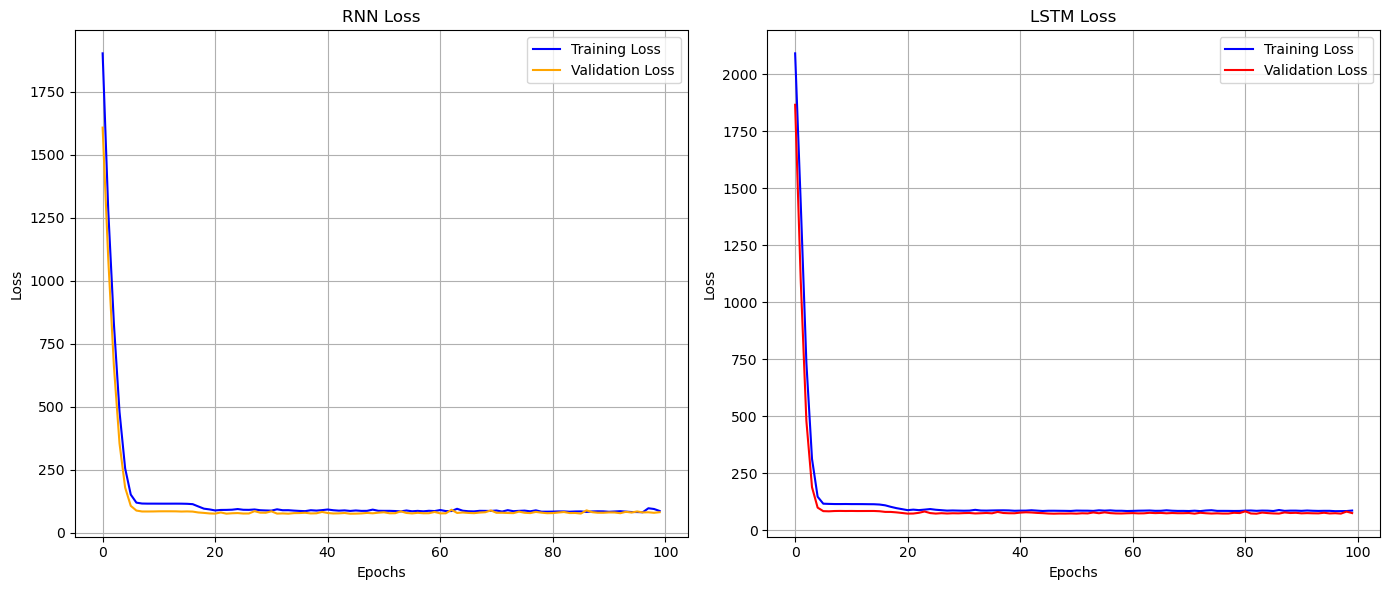

In [52]:
import matplotlib.pyplot as plt

def plot_loss(h_rnn, h_lstm):
    plt.figure(figsize=(14, 6))

    # RNN Loss
    plt.subplot(1, 2, 1)
    plt.plot(h_rnn.history['loss'], label='Training Loss', color='blue')
    plt.plot(h_rnn.history['val_loss'], label='Validation Loss', color='orange')
    plt.title('RNN Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    # LSTM Loss
    plt.subplot(1, 2, 2)
    plt.plot(h_lstm.history['loss'], label='Training Loss', color='blue')
    plt.plot(h_lstm.history['val_loss'], label='Validation Loss', color='red')
    plt.title('LSTM Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

# Call the function to plot the losses
plot_loss(h_rnn, h_lstm)
plot_loss(hist_rnn, hist_lstm)



### C) Comment on how many epochs are required for adequate learning.              

- around 30 epochs are sufficient since we dont see the loss reducing significantly after that.

In [ ]:
#Doubt: why is val loss lesser than train loss ????


### D) Plot the actual vs predicted values using the test data for the year 2016.   

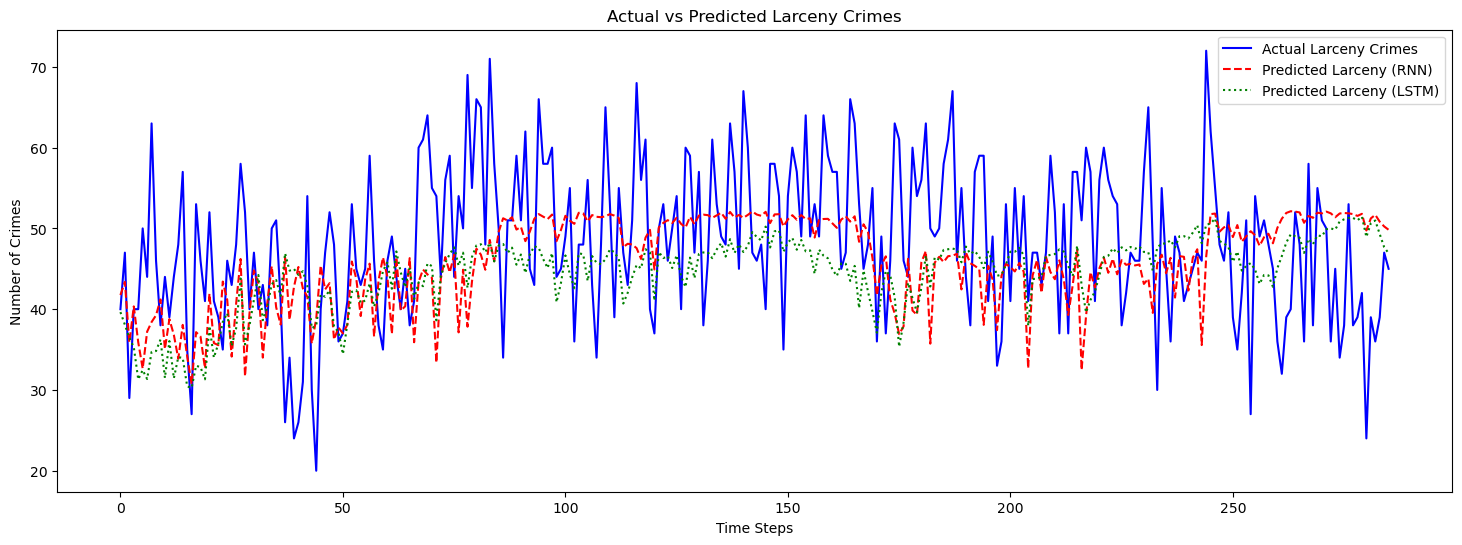

In [49]:
import matplotlib.pyplot as plt

# Prepare the actual values for plotting
actual_larceny = y_larceny[-len(predicted_larceny_rnn):]

plt.figure(figsize=(18, 6))
plt.plot(actual_larceny, label='Actual Larceny Crimes', color='blue')
plt.plot(predicted_larceny_rnn, label='Predicted Larceny (RNN)', color='red', linestyle='dashed')
plt.plot(predicted_larceny_lstm, label='Predicted Larceny (LSTM)', color='green', linestyle='dotted')
plt.title('Actual vs Predicted Larceny Crimes')
plt.xlabel('Time Steps')
plt.ylabel('Number of Crimes')
plt.legend()
plt.show()


#### Conclusion:
- We see that the predicted number of larceny crimes is close to actual, but its not the case for burglary crimes.
- Total Larceny Crimes: 101647
- Total Burglary Crimes: 44977
- Total Predicted Larceny Crimes (RNN): 13111.208984375
- Total Predicted Larceny Crimes (LSTM): 12733.97265625
- Total Predicted burglary Crimes (RNN): 9714.4912109375
- Total Predicted burglary Crimes (LSTM): 8577.146484375
